## Install the PGR-TK package

If neccessary, install the package into your python environment 
```
pip install --force /code/pgrtk-0.3.2-cp38-cp38-linux_x86_64.whl
```

In [1]:
import pgrtk
import os
import matplotlib.pyplot as plt
from IPython.display import SVG
%matplotlib inline

In [2]:
pgrtk.__version__

'pgrtk 0.3.4 (main:59af6a0, release build, linux [x86_64] [rustc 1.62.0 (a8314ef7d 2022-06-27)])'

In [3]:
os.chdir("/results")

## Lazy load the the AGCfile for fetching sequences

In [4]:
ref_db =pgrtk.AGCFile("/data/pgr-tk-HGRP-y1-evaluation-set-v0.agc") # lazy load an agc file of the reference without any SHIMMER index 

## Load the index into memory
The loads the index into the memory. It takes about one minute.

In [5]:
%%time
sdb = pgrtk.SeqIndexDB()
sdb.load_from_agc_index("/data/pgr-tk-HGRP-y1-evaluation-set-v0")

CPU times: user 23.9 s, sys: 5min 20s, total: 5min 44s
Wall time: 33.4 s


We can see the specification about how SHIMMERs are computed using the `get_shmmr_spec()` method. 

In [6]:
sdb.get_shmmr_spec() # window_size, k_mer_size, hieraical_reduction_factor, min_span, use_k_mer_sketch_other_than_minimizer

(80, 56, 4, 64, False)

## Query the database with HLA-Class II region sequences 

We use a copy of the annotation for IGV hg19 to look up the chromosome and locations of the gene of interest.
We can fetch the region of interest with `ref_db`. Let's fetch the whole region and do a dot plot to examine the repeat structure. 

49


(0.0, 828999.0)

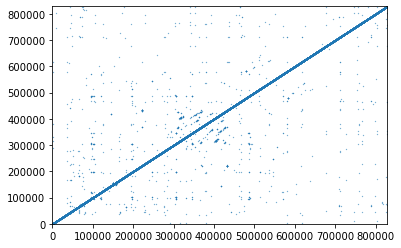

In [7]:
ref_file_name, roi_chr, roi_b, roi_e = 'hg19_tagged.fa', "chr6_hg19", 32130918, 32959917
padding = 0

#get a segment of a reference
roi_seq = ref_db.get_sub_seq(ref_file_name, roi_chr, roi_b-padding, roi_e+padding)
x, y = pgrtk.get_shmmr_dots(roi_seq, roi_seq, 32, 32, 2, 2)
plt.plot(x, y, ".", markersize=0.5)
print(x[0])
plt.xlim(0,len(roi_seq))
plt.ylim(0,len(roi_seq))

In [8]:
#find hits in the pangenomic reference
aln_range = pgrtk.query_sdb(sdb, roi_seq, merge_range_tol=200000)

print("The number of hits is", len(aln_range))

count = 0
for sid, rgns in aln_range.items():
    count += len(rgns)

print("The total aligned regions is", count)

The number of hits is 114
The total aligned regions is 147


We can examine, the target region sizes.

In [9]:
rgn_lengths = []
for k in list(aln_range.keys()):
    b, e = aln_range[k][0][0:2]
    print(sdb.seq_info[k], "target region", b, "-", e, "len:", e-b )
    rgn_lengths.append(e-b)

('HG02818#1#JAHEOS010000026.1', 'HG02818.paternal.f1_assembly_v2_genbank.fa', 27438479) target region 3503365 - 4325934 len: 822569
('HG02886#1#JAHAOU010000006.1', 'HG02886.paternal.f1_assembly_v2_genbank.fa', 55496981) target region 22522980 - 23317712 len: 794732
('chr6_GL000250v2_alt_hg38', 'hg38_tagged.fa', 4672374) target region 3497464 - 3812023 len: 314559
('HG03453#2#JAGYVV010000230.1', 'HG03453.maternal.f1_assembly_v2_genbank.fa', 5546504) target region 3402532 - 4193513 len: 790981
('HG02145#1#JAHKSG010000017.1', 'HG02145.paternal.f1_assembly_v2_genbank.fa', 11219473) target region 6953506 - 7772155 len: 818649
('HG01175#2#JAHALZ010000032.1', 'HG01175.maternal.f1_assembly_v2_genbank.fa', 31257284) target region 23360059 - 24179654 len: 819595
('HG00733#1#JAHEPQ010000070.1', 'HG00733.paternal.f1_assembly_v2_genbank.fa', 39879370) target region 32136286 - 32923993 len: 787707
('HG03453#1#JAGYVW010000148.1', 'HG03453.paternal.f1_assembly_v2_genbank.fa', 5669647) target region 13

Text(0, 0.5, 'count')

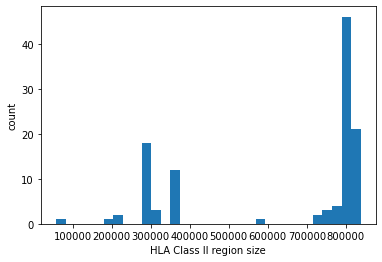

In [10]:
plt.hist(rgn_lengths, bins=32);
plt.xlabel("HLA Class II region size")
plt.ylabel("count")

Some mapped regions are larger, let's check the repeat / CNV by quick dot plots

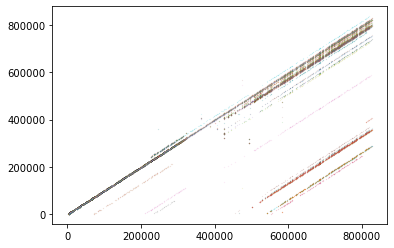

In [11]:
seq_list = []
i = 0
seq_info = sdb.seq_info.copy()
for k in list(aln_range.keys()):
    ctg_name, source, _ = seq_info[k]
    seq_id = k
    rgns = aln_range[k].copy()
   
    for rgn in rgns:
        b, e, length, orientation, aln = rgn

        seq =  sdb.get_sub_seq(source, ctg_name, b, e)
       
        if orientation == 1:
            seq = pgrtk.rc_byte_seq(seq)
  
        seq_list.append((i, "{}_{}_{}_{}".format(ctg_name, b, e, orientation), seq))
        
        x, y = pgrtk.get_shmmr_dots(roi_seq, seq, 80, 56, 12, 1)
        plt.plot(x, y, ".", markersize=0.1)
        i += 1



## Create a new shimmer database for the detailed study

In [12]:
seq_list = []
i = 0
for k in list(aln_range.keys()):
    ctg_name, source, _ = seq_info[k]
    seq_id = k
    rgns = aln_range[k].copy()
    
    rgns = pgrtk.merge_regions(rgns,tol=1000)

    for rgn in rgns:
        b, e, length, orientation, aln = rgn
 
        seq =  sdb.get_sub_seq(source, ctg_name, b, e)
        if orientation == 1:
            seq = pgrtk.rc_byte_seq(seq)
  
        seq_list.append(("{}_{}_{}_{}".format(ctg_name, b, e, orientation), seq))
        
        i += 1



Create a shimmer indext database with smaller window (denser shimmers)

In [13]:
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=128, k=56, r=12, min_span=8)

In [14]:
len(new_sdb.seq_info)

147

In [15]:
#find hits in the pangenomic reference
aln_range0 = pgrtk.query_sdb(new_sdb, roi_seq, merge_range_tol=300000)

aln_range = aln_range0

print("The number of hits is", len(aln_range))

count = 0
for sid, rgns in aln_range.items():
    count += len(rgns)

print("The total aligned regions is", count)

The number of hits is 147
The total aligned regions is 151


Let's loop through the hits (contigs that has alignments) and see the number of "copies".

In [16]:
from collections import Counter

In [17]:
n_copy = {}
for k in list(aln_range.keys()):
    n_copy[k] = len(aln_range[k])
copy_count = Counter(n_copy.values())
for nc, nh in copy_count.items():
    print("number of copy: {}, number of haplotypes: {}".format(nc, nh))

number of copy: 1, number of haplotypes: 143
number of copy: 2, number of haplotypes: 4


Text(0, 0.5, 'count')

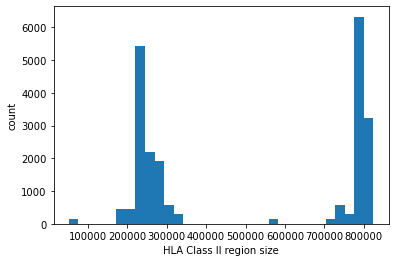

In [18]:
rgn_lengths = []
for k in list(aln_range.keys()):
    for sid, rgns in aln_range.items():
        for rgn in rgns:
            b, e = rgn[0:2]
            #print(seq_index[k], "target region", b, "-", e, "len:", e-b )
            rgn_lengths.append(e-b)
plt.hist(rgn_lengths, bins=32);
plt.xlabel("HLA Class II region size")
plt.ylabel("count")

In [19]:
f0 = open("/results/HLA-ClassII_seq.fa", "w")
for ctg, seq in seq_list:
    
    print(">{}".format(ctg), file=f0)
    print(pgrtk.u8_to_string(seq), file=f0)
       
f0.close()

In [20]:
help(new_sdb.generate_mapg_gfa)

Help on built-in function generate_mapg_gfa:

generate_mapg_gfa(...) method of builtins.SeqIndexDB instance
    Convert the adjecent list of the shimmer graph shimmer_pair -> GFA
    
    Parameters
    ----------
    min_count : int
        the minimum number of times a pair of shimmers must be observed to be included in the graph
    
    filenpath : string
        the path to the output file
    
    Returns
    -------
    
    None
        The data is written into the file at filepath



In [21]:
new_sdb.generate_mapg_gfa(0, "/results/HLA-ClassII_128_56_12_8.gfa")
new_sdb.write_mapg_idx("/results/HLA-ClassII_128_56_12_8.gidx")

## Construct the genome graphs

In [22]:
import networkx as nx
from networkx.drawing import nx_pydot 

In [23]:
def get_graph(seq_list, w=128, k=56, r=4, min_span=1, highlite=0):
    new_sdb = pgrtk.SeqIndexDB() 
    new_sdb.load_from_seq_list(seq_list, w=w, k=k, r=r, min_span=8)
    new_sdb.generate_mapg_gfa(0, f"/results/{name}-{w}-{k}-{r}.gfa")
    sid_to_path = {}
    spl=new_sdb.get_shmmr_pair_list()
    for (k0, k1, sid, p0, p1, o) in spl:
        sid_to_path.setdefault(sid,[])
        sid_to_path[sid].append((p0, p1, o, k0, k1))
    G = nx.DiGraph()
    m = new_sdb.get_shmmr_map()
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        #if sid != 45:
        #    continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "yellow"
            penwidth =  2 + 0.1 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_edge(v, w, penwidth = penwidth, color="orange" )
            G.add_node(v, fillcolor=color, style="filled")
            #G.add_node(w, size =  len(m[v]))
            v = w
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        if sid != highlite:
            continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "blue"
            penwidth =  2 + 0.1 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_node(v, fillcolor=color, style="filled")
            G.add_edge(v, w, penwidth = penwidth, color=color )
            v = w
    return G
    

In [24]:
def get_graph2(seq_list, w=128, k=56, r=4, min_span=1, highlite=0):
    new_sdb = pgrtk.SeqIndexDB() 
    new_sdb.load_from_seq_list(seq_list, w=w, k=k, r=r, min_span=8)
    new_sdb.generate_mapg_gfa(0, f"/results/{name}-{w}-{k}-{r}.gfa")
    sid_to_path = {}
    spl=new_sdb.get_shmmr_pair_list()
    for (k0, k1, sid, p0, p1, o) in spl:
        sid_to_path.setdefault(sid,[])
        sid_to_path[sid].append((p0, p1, o, k0, k1))
    G = nx.DiGraph()
    m = new_sdb.get_shmmr_map()
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        #if sid != 45:
        #    continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "yellow"
            penwidth =  1 + 0.03 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_edge(v, w, penwidth = penwidth, color="orange" )
            G.add_edge(w, v, penwidth = penwidth, color="orange" )
            G.add_node(v, fillcolor=color, style="filled")
            #G.add_node(w, size =  len(m[v]))
            v = w
            
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        if sid != highlite:
            continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "blue"
            penwidth =  1 + 0.05 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_node(v, fillcolor=color, style="filled")
            G.add_edge(v, w, penwidth = penwidth, color=color )
            G.add_edge(w, v, penwidth = penwidth, color=color )
            v = w
    return G
    

## Generate Repeat Pattern Using the Principal Bundles

In [25]:
import numpy as np

In [26]:
shmmrspec = {"w": 128, "k":56, "r":6, "min_span":28 }
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, 
                           w = shmmrspec["w"], 
                           k = shmmrspec["k"], 
                           r = shmmrspec["r"], 
                           min_span = shmmrspec["min_span"])

In [27]:
principal_bundles, sid_smps = new_sdb.get_principal_bundle_decomposition(0,8)
sid_to_smps = dict(sid_smps)
print(len(principal_bundles))

322


In [28]:
import numpy as np
from matplotlib import cm

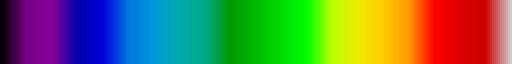

In [29]:
cmap=plt.get_cmap("nipy_spectral")
cmap

In [30]:
lpb = len(principal_bundles)
color_theme0 = cmap(np.linspace(0.1, 0.9, lpb))
#pseudo-randomize the colors
idx = np.array([_ * (lpb+8011) for _ in range(lpb)]) % lpb
print(idx)
color_theme = color_theme0[idx]

[  0 283 244 205 166 127  88  49  10 293 254 215 176 137  98  59  20 303
 264 225 186 147 108  69  30 313 274 235 196 157 118  79  40   1 284 245
 206 167 128  89  50  11 294 255 216 177 138  99  60  21 304 265 226 187
 148 109  70  31 314 275 236 197 158 119  80  41   2 285 246 207 168 129
  90  51  12 295 256 217 178 139 100  61  22 305 266 227 188 149 110  71
  32 315 276 237 198 159 120  81  42   3 286 247 208 169 130  91  52  13
 296 257 218 179 140 101  62  23 306 267 228 189 150 111  72  33 316 277
 238 199 160 121  82  43   4 287 248 209 170 131  92  53  14 297 258 219
 180 141 102  63  24 307 268 229 190 151 112  73  34 317 278 239 200 161
 122  83  44   5 288 249 210 171 132  93  54  15 298 259 220 181 142 103
  64  25 308 269 230 191 152 113  74  35 318 279 240 201 162 123  84  45
   6 289 250 211 172 133  94  55  16 299 260 221 182 143 104  65  26 309
 270 231 192 153 114  75  36 319 280 241 202 163 124  85  46   7 290 251
 212 173 134  95  56  17 300 261 222 183 144 105  6

In [31]:
new_sdb.generate_mapg_gfa(0, "/results/test_48_56_4_28.gfa")

v_to_name = {}
with open("/results/test_48_56_4_28.gfa") as f:
    for r in f:
        r = r.strip().split("\t")
        if r[0] != "S":
            continue
        n = r[1]
        v = r[4].split(":")[-1]
        v_to_name[v] = n

f = open("/results/test_48_56_4_28_color.csv", "w")
print("Name,Color", file=f)
for bundle_id, bundle in enumerate(principal_bundles):
    for v in bundle[2]:
        vertex = tuple(v[:2])
        color = color_theme[bundle_id]
  
        print(v_to_name["{:016x}_{:016x}".format(*vertex)], color, file=f, sep=",")
f.close()

In [32]:
b_vertex_to_position = {}
i = 0
for bundle in principal_bundles:
    for v in bundle[2]:
        vertex = tuple(v[:2])
        b_vertex_to_position[vertex] = i, bundle[0]
        i += 1

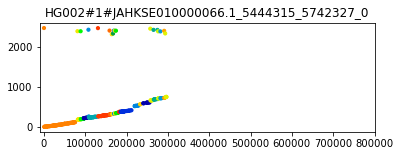

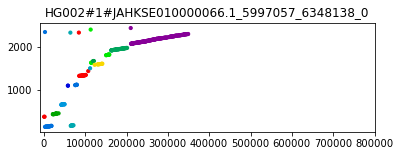

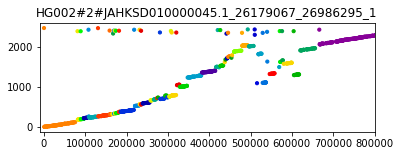

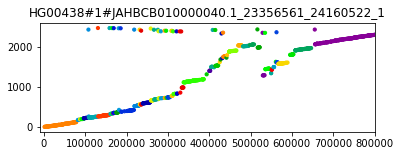

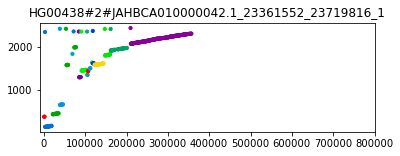

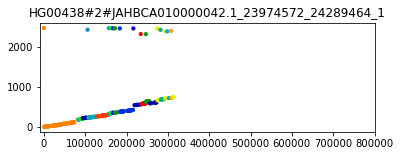

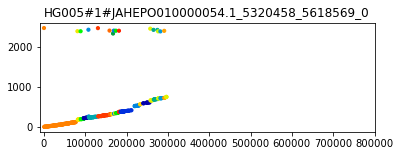

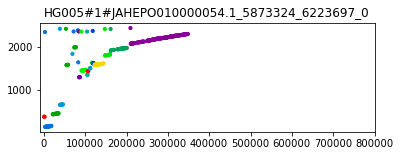

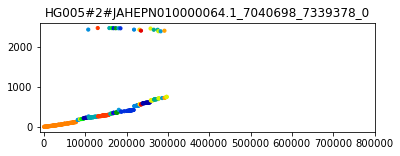

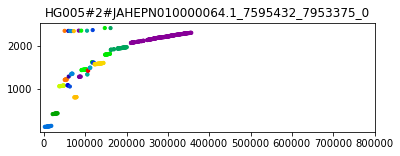

In [33]:
seq_info = new_sdb.seq_info.copy()
sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])

#fig = plt.figure(figsize=(24,96))
pidx = 1
for sid, data in sinfo[:10]:
    ctg, _, _ = data
    smps = sid_to_smps[sid]
    #print(seq_info[sid])
    #print(sid, len(smps))
    x, rx = [], []
    y, ry = [], []
    c, rc = [], []
    for s in smps:
        if s[1] is None:
            continue
        vertex = tuple(s[0][:2])
        x.append(s[0][2])
        y.append(b_vertex_to_position[vertex][0]) # same direction
        c.append(color_theme[s[1][0]])
            

    fig = plt.figure(figsize=(6,2))
    plt.scatter(x, y, marker=".", color=c, s=40)
    
    
    plt.xlim(-10000,800000)
    plt.title(ctg)
    

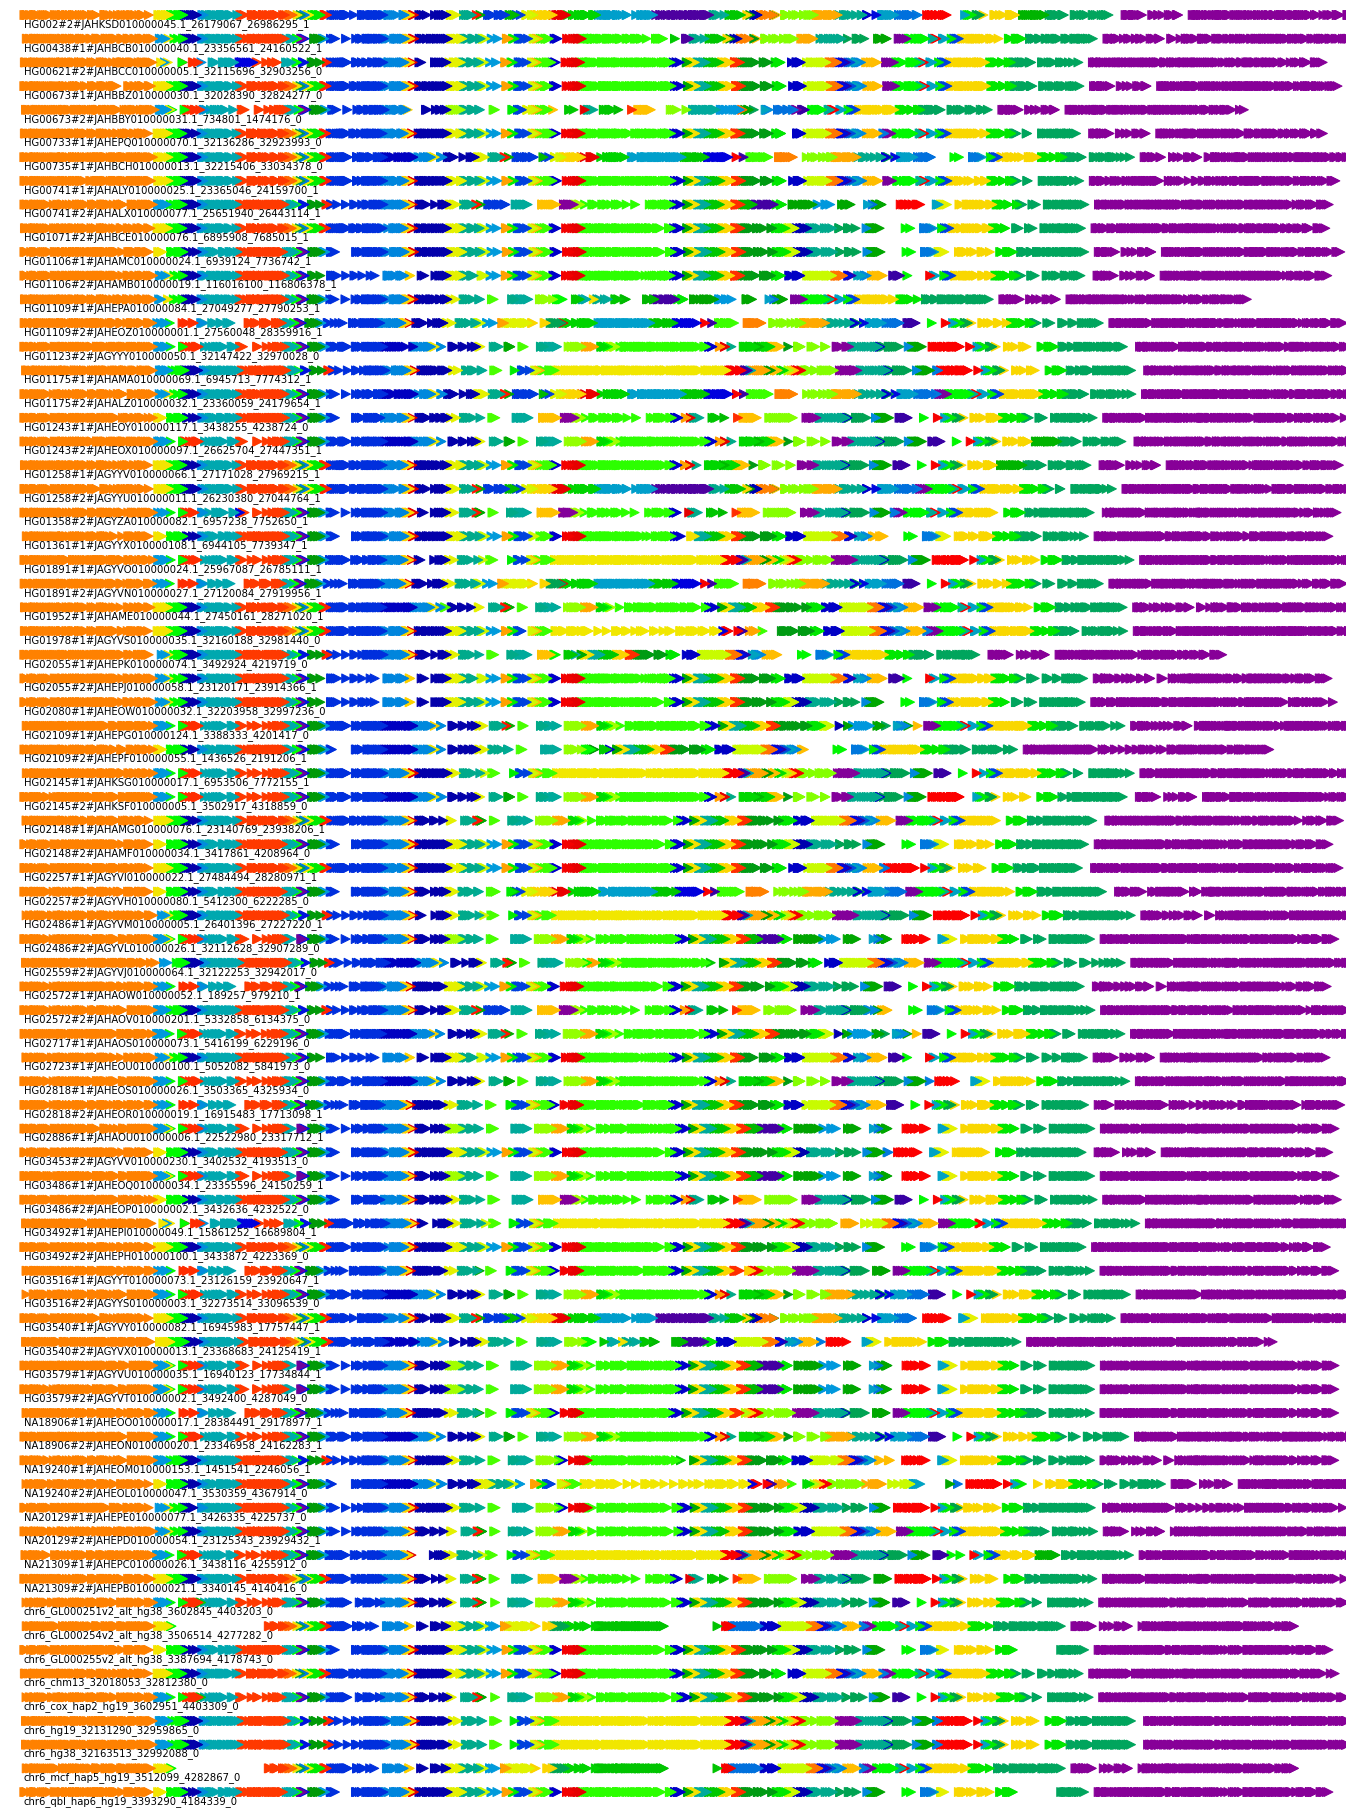

In [34]:
seq_info = new_sdb.seq_info.copy()
sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])

fig = plt.figure(figsize=(24,64))
pidx = 1
ctg_labels = []
full_length_sids = set()
for sid, data in sinfo:
    
    ctg, _, slen = data
    ctg_labels.append(ctg)
    if slen < 600000:
        continue
    full_length_sids.add(sid)
    smps = sid_to_smps[sid]
    
    #print(seq_info[sid])
    #print(sid, len(smps))
    x, rx = [], []
    y, ry = [], []
    c, rc = [], []
    track0_x = []
    track0_c = []
   
    for s in smps:
        if s[1] is None:
            continue
        
        if s[0][4] == s[1][1]:
            x.append(s[0][2])
            y.append(0) # same direction
            c.append(color_theme[s[1][0]])
        else:
            rx.append(s[0][2])
            ry.append(6)
            rc.append(color_theme[s[1][0]])

            
    y = np.array(y) 
    ry = np.array(ry)
    x.reverse()
    c.reverse()
    
    plt.subplot(len(sid_smps), 1, pidx)

    pidx += 1
    plt.scatter(x, y, marker=">", color=c, s=80)
    plt.scatter(rx, ry, marker="<", color=rc, s=80)
    
    plt.scatter(track0_x, [-6]*len(track0_x), marker="s", color="black", s=20)
    
    plt.axis("off")
    plt.ylim(-12,8)
    plt.xlim(-10000,800000)
    plt.text(0, -12, ctg)

## PCA Analysis

In [35]:
from sklearn.decomposition import PCA

In [36]:
sample2eth = {}
with open("/code/HPRC_y1_ethnic.csv") as f:
    for r in f:
        r = r.strip().split()
        sample2eth[r[0]] = r[2]

In [37]:
eths = []
for c in ctg_labels:
    print(c, sample2eth.get(c.split("#")[0], "NA"))
    eths.append(sample2eth.get(c.split("#")[0], "NA"))

HG002#1#JAHKSE010000066.1_5444315_5742327_0 AMR
HG002#1#JAHKSE010000066.1_5997057_6348138_0 AMR
HG002#2#JAHKSD010000045.1_26179067_26986295_1 AMR
HG00438#1#JAHBCB010000040.1_23356561_24160522_1 EAS
HG00438#2#JAHBCA010000042.1_23361552_23719816_1 EAS
HG00438#2#JAHBCA010000042.1_23974572_24289464_1 EAS
HG005#1#JAHEPO010000054.1_5320458_5618569_0 EAS
HG005#1#JAHEPO010000054.1_5873324_6223697_0 EAS
HG005#2#JAHEPN010000064.1_7040698_7339378_0 EAS
HG005#2#JAHEPN010000064.1_7595432_7953375_0 EAS
HG00621#1#JAHBCD010000020.1_23360091_23711816_1 EAS
HG00621#1#JAHBCD010000020.1_23966447_24265104_1 EAS
HG00621#2#JAHBCC010000005.1_32115696_32903256_0 EAS
HG00673#1#JAHBBZ010000030.1_32028390_32824277_0 EAS
HG00673#2#JAHBBY010000031.1_734801_1474176_0 EAS
HG00733#1#JAHEPQ010000070.1_32136286_32923993_0 AMR
HG00733#2#JAHEPP010000060.1_26893186_27481359_1 AMR
HG00733#2#JAHEPP010000166.1_5000_204370_1 AMR
HG00735#1#JAHBCH010000013.1_32215406_33034378_0 AMR
HG00735#2#JAHBCG010000038.1_3503667_3800803_0 A

construct vector of each repet unit by the projection to the bundles

In [38]:
b_vertex_to_position = {}
i = 0
for bundle in principal_bundles:
    if len(bundle[2]) == 1: # some small segment used in both directions
        continue
    for v in bundle[2]:
        vertex = tuple(v[:2])
        if vertex in b_vertex_to_position: # some small segment used in both directions
            continue
        b_vertex_to_position[vertex] = i, bundle[0]
        i += 1

In [39]:

seq_info = new_sdb.seq_info.copy()

sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])


index_indx_sid = dict([(_[0], _[1]) for _ in enumerate(sorted(list(full_length_sids)))])
sid_to_index = dict([(_[1], _[0]) for _ in enumerate(sorted(list(full_length_sids)))])
s_vectors = np.zeros( (len(sid_to_index), len(b_vertex_to_position)))

ctg_labels = [""]*len(sid_to_smps)


for sid, smps in sid_to_smps.items():
    if sid not in full_length_sids:
        continue
    ctg, src, _ = seq_info[sid]
    for smp, bundle_id in smps:
        if bundle_id is None:
            continue
        node = smp[0], smp[1]
        direction = smp[4]
        
        if node in b_vertex_to_position:
            idx = sid_to_index[sid]
            s_vectors[idx, b_vertex_to_position[node][0]] += 1
    ctg_labels[sid]=ctg



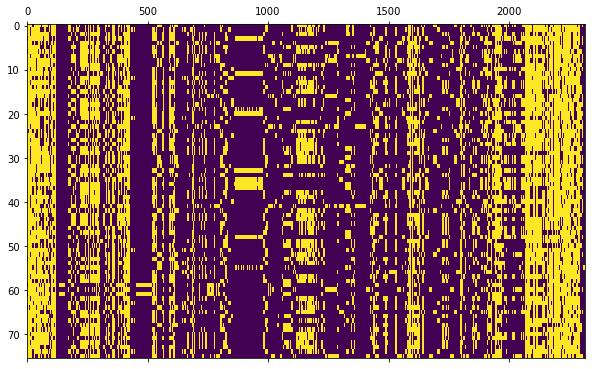

In [40]:
plt.figure(figsize=(10,6))
plt.matshow(s_vectors, fignum=1,  aspect='auto')

create a PCA plot of the repeat-bundle projection vectors 

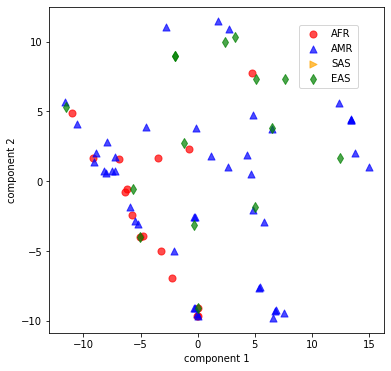

In [41]:
pca = PCA(n_components=2)
comp = pca.fit_transform(s_vectors)

[x, y] = zip( *[ (_[0], _[1]) for _ in comp ] )
c_map = {"AFR":"red", "AMR": "blue", "SAS": "orange", "EAS":"green" }
m_map = {"AFR":"o", "AMR": "^", "SAS": ">", "EAS":"d" }
colors = []

ax=plt.figure(figsize=(6,6))
for eth, color in c_map.items():
    xx = []
    yy = []
    for i in range(len(x)):
        #plt.text(x[i], y[i], eths[i])
        if eths[i] != eth:
            continue
        xx.append(x[i])
        yy.append(y[i])
    plt.scatter(xx, yy, alpha=0.7, marker=m_map[eth], c=color, s=50, label=eth)

ax.legend(bbox_to_anchor=(0.850, 0.85), loc="upper right")

plt.xlabel("component 1")
plt.ylabel("component 2")
pca_x = x[:]
pca_y = y[:]